In [2]:
import pandas as pd
import numpy as np
import warnings
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

In [3]:
print("--- 1. Data Loading and Modification ---")
# Load the dataset
data = pd.read_csv('data/iris.csv')

# Introduce a "location" attribute with random 0s and 1s
np.random.seed(42) # for reproducibility
data['location'] = np.random.randint(0, 2, data.shape[0])

print("Successfully added random 'location' attribute.")
print("Data head:")
data.head()

--- 1. Data Loading and Modification ---
Successfully added random 'location' attribute.
Data head:


,sepal_length,sepal_width,petal_length,petal_width,species,location
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


In [4]:
print("\n--- 2. Model Training ---")

# --- Data Preparation ---
X = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y_raw = data['species']
sensitive_features = data['location']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
class_names = label_encoder.classes_
print(f"Target classes: {class_names}")

# Split the data
X_train, X_test, y_train, y_test, sensitive_features_train, sensitive_features_test = train_test_split(
    X, y, sensitive_features, test_size=0.3, random_state=42, stratify=y
)

# Train the model
model = LogisticRegression(max_iter=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Model trained. Overall Accuracy: {overall_accuracy:.4f}")


--- 2. Model Training ---
Target classes: ['setosa' 'versicolor' 'virginica']
Model trained. Overall Accuracy: 0.9333


In [6]:
print("\n--- 3. Fairness Analysis with Fairlearn ---")

# Use MetricFrame to analyze metrics grouped by the sensitive 'location' feature
metrics = {
    'accuracy': accuracy_score,
    'selection_rate': selection_rate # how often the model predicts each class
}
grouped_on_location = MetricFrame(metrics=metrics,
                                  y_true=y_test,
                                  y_pred=y_pred,
                                  sensitive_features=sensitive_features_test)

# Get the results and print them
fairness_results = grouped_on_location.by_group
print("Fairness metrics grouped by 'location':")
print(fairness_results)

# Analyze the results for bias
acc_diff = abs(fairness_results['accuracy'][0] - fairness_results['accuracy'][1])
print(f"\nDifference in accuracy between Location 0 and Location 1: {acc_diff:.4f}")
if acc_diff > 0.1:
    print("Indication of potential accuracy disparity bias.")
else:
    print("Accuracy appears balanced across locations.")


--- 3. Fairness Analysis with Fairlearn ---
Fairness metrics grouped by 'location':
          accuracy  selection_rate
location                          
0         0.952381        0.285714
1         0.916667        0.416667

Difference in accuracy between Location 0 and Location 1: 0.0357
Accuracy appears balanced across locations.



--- 4. Explainability Analysis with SHAP ---
The class 'virginica' corresponds to index 2.

Generating SHAP summary plot for class 'virginica'...


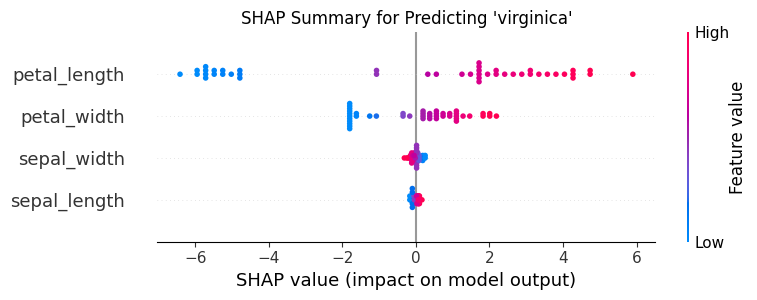

In [11]:
print("\n--- 4. Explainability Analysis with SHAP ---")

# Use the modern, unified Explainer API
# This will automatically choose the best explainer for your model
explainer = shap.Explainer(model, X_train)

# Calculate a SHAP Explanation object for the test set
shap_explanation = explainer(X_test)

# Find the index for the 'virginica' class for plotting
virginica_index = list(class_names).index('virginica')
print(f"The class 'virginica' corresponds to index {virginica_index}.")

# Create and display the summary plot by slicing the Explanation object
print("\nGenerating SHAP summary plot for class 'virginica'...")
plt.title("SHAP Summary for Predicting 'virginica'")
shap.summary_plot(shap_explanation[:, :, virginica_index], X_test)